In [1]:
reset -sf

In [63]:
%pylab inline
import pickle
import pandas as pd
import numpy as np
from os import path
from PIL import Image
import nltk
import gensim
from gensim import corpora, models
from gensim.models.doc2vec import LabeledSentence
from collections import Counter

from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition.online_lda import LatentDirichletAllocation

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from wordcloud import WordCloud

Populating the interactive namespace from numpy and matplotlib


#### Data set:
>New York Times data set. There is 1405 articles, and there is 10 sections.<br>
There are Sports, World, Opinion, Business Day, U.S., Arts, Magazine, Travel, Books, Real Estate sections exist in NYT, <br>but I clean the data into Top 6 sections other 4 sections only contain 1 or 2 articles.

#### Hypothesis:

>NN, NNP are the most important words which can explain sections of articles by only these elements (contains the most of informations about sections).

#### Goal and Method:
>Develop to topic modeling system with NN & NNP combination data, and to show improvement petition for section modeling.<br>

* Training data: One content for each section which is consist of NN and NNP words from original articles.
* Test data: orginal articels.


#### EDA

In [157]:
nyt = pd.read_pickle('nyt_articles.pkl')

In [158]:
nyt.head(2)

,document_type,web_url,lead_paragraph,abstract,snippet,news_desk,word_count,source,section_name,subsection_name,_id,pub_date,print_page,headline,content
0,article,http://www.nytimes.com/2013/10/03/sports/footb...,You would think that in a symmetric zero-sum s...,None,You would think that in a symmetric zero-sum s...,Sports,347,The New York Times,Sports,Pro Football,524d4e3a38f0d8198974001f,2013-10-03T00:00:00Z,None,Week 5 Probabilities: Why Offense Is More Impo...,the original goal building model football fore...
1,article,http://www.nytimes.com/2013/10/03/us/new-immig...,House Democrats on Wednesday unveiled an immig...,House Democrats unveil immigration bill that p...,House Democrats on Wednesday unveiled an immig...,National,83,The New York Times,U.S.,None,524cf71338f0d8198973ff7b,2013-10-03T00:00:00Z,21,New Immigration Bill Put Forward,house unveiled immigration bill provides path ...


In [159]:
nyt.shape

(1405, 15)

In [160]:
# Look at a sample of the data - content of the news stories
nyt.content[:2]

0    the original goal building model football fore...
1    house unveiled immigration bill provides path ...
Name: content, dtype: object

In [161]:
#see columns in order to clean data
nyt.columns

Index(['document_type', 'web_url', 'lead_paragraph', 'abstract', 'snippet',
       'news_desk', 'word_count', 'source', 'section_name', 'subsection_name',
       '_id', 'pub_date', 'print_page', 'headline', 'content'],
      dtype='object')

Sports          340
World           260
Opinion         224
Business Day    209
U.S.            190
Arts            176
Travel            2
Magazine          2
Books             1
Real Estate       1
Name: section_name, dtype: int64


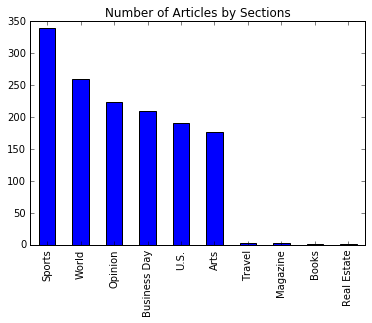

In [162]:
#plotting groupby section_name
fig = plt.figure()
plt.title('Number of Articles by Sections')
print(nyt['section_name'].value_counts())
nyt['section_name'].value_counts().plot(kind='bar');

In [163]:
#clean data set, data set contains section_name and content
nyt = nyt[['section_name', 'content']]
nyt.head(2)

,section_name,content
0,Sports,the original goal building model football fore...
1,U.S.,house unveiled immigration bill provides path ...


In [164]:
#describe data set infomations
#there is 340 articles in sport section, and some articles are duplicated
nyt.describe()

,section_name,content
count,1405,1405
unique,10,1397
top,Sports,lot list should-be-better-known movie include ...
freq,340,2


In [165]:
#check the sections
nyt.section_name.unique()

array(['Sports', 'U.S.', 'Business Day', 'World', 'Opinion', 'Arts',
       'Travel', 'Magazine', 'Real Estate', 'Books'], dtype=object)

In [166]:
#clean sections, leave sections which have more than 150 articles, more than 15% out of whole articles.
list_sections = ['Sports', 'Business Day', 'U.S.', 'World', 'Opinion', 'Arts']
clean = nyt['section_name'].isin(list_sections)
nyt = nyt[clean]
nyt.shape

(1399, 2)

Sports          340
World           260
Opinion         224
Business Day    209
U.S.            190
Arts            176
Name: section_name, dtype: int64


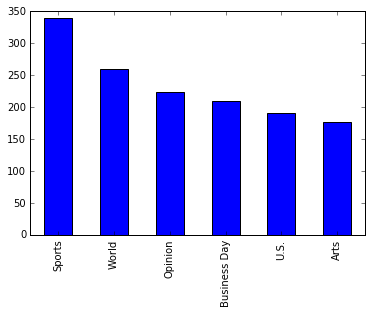

In [167]:
#counting number of articles groupby in sections
print(nyt['section_name'].value_counts())
nyt['section_name'].value_counts().plot(kind='bar');

In [168]:
#total number of articles which is related with economy.
nyt.content.size

1399

#### Making New DataFrame which is the same content as Original content, but only contains NN and NNP.

In [191]:
new_nyt = nyt[['section_name', 'content']]

In [192]:
#make lowercase letter
new_nyt['content'] = new_nyt['content'].apply(lambda x: str(x).lower())

In [193]:
#show list of sections
list_section = list(new_nyt.section_name.unique())
list_section

['Sports', 'U.S.', 'Business Day', 'World', 'Opinion', 'Arts']

In [194]:
#tokenize each article into words(tokens)
RT = RegexpTokenizer(r'\w+')
new_nyt['content'] = new_nyt['content'].apply(lambda x: RT.tokenize(x))

In [195]:
#clean data like a, the ...
sw = stopwords.words('english')
noise_words = ['mr', 'year', 'day', 'time', 'month', 'week']
new_nyt['content'] = new_nyt['content'].apply(lambda x: [i for i in x if i not in sw+noise_words])

In [196]:
PS = PorterStemmer()
new_nyt['content'] = new_nyt['content'].apply(lambda x: [PS.stem(i) for i in x])

### Input Shape for Tf-idf or Count vectorizer

In [181]:
#clean the data for , [, ] and make lowercase letter (Input for Tf-idf or Count vectorizer)
new_nyt['content'] = new_nyt['content'].apply(lambda x: str(x).replace("', '", " ").replace("['", " ").replace("']", " "))

### NMF or LDA

In [182]:
# NMF is able to use tf-idf
Tfidf_vec = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
Tfidf_fit = Tfidf_vec.fit_transform(new_nyt.content)
Tfidf_feature_names = Tfidf_vec.get_feature_names()
Tfidf_fit.shape

(1399, 1000)

In [183]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
Tf_vec = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
Tf_fit = Tf_vec.fit_transform(new_nyt.content)
Tf_feature_names = Tf_vec.get_feature_names()
Tf_fit.shape

(1399, 1000)

In [184]:
# Run NMF
nmf = NMF(n_components=6, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd').fit(Tfidf_fit)

# Run LDA
lda = LatentDirichletAllocation(n_topics=6, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0).fit(Tf_fit)

In [185]:
#colormap function in order to call from WordCloud
class colormap_color_func(object):
    def __init__(self, colormap):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(random_state.uniform(0, 1)))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [186]:
#Use Christmas Tree for word cloud mask
def TreeCloud(text, sec):
    christTree_mask = np.array(Image.open(path.join("christTree.png")))

    wc = WordCloud(color_func=colormap_color_func('magma'), background_color="black", max_words=50,\
                   mask=christTree_mask, random_state=42, stopwords=sw, relative_scaling=1)
    wc.generate(text)
    
    plt.figure(figsize=(10,10))
    plt.title('<{0}>'.format(sec), size=20)
    plt.imshow(wc)
    plt.axis('off')

In [187]:
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic%d:" %topic_idx)
        topic = (" | ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print(topic)
        TreeCloud(topic, topic_idx)

Topics in LDA model:

Topic0:
said | game | season | team | play | one | two | first | player | last | like | go | run | would | yanke | three | leagu | win | get | start

Topic1:
yard | said | first | game | gun | touchdown | sept | two | quarterback | defens | point | one | giant | child | 10 | jet | would | sunday | smith | season

Topic2:
new | work | like | compani | one | ms | said | citi | peopl | york | show | also | music | make | world | mani | art | execut | even | perform

Topic3:
said | republican | would | govern | hous | health | law | senat | care | state | feder | presid | new | obama | shutdown | democrat | one | bill | peopl | congress

Topic4:
said | unit | iran | offici | state | attack | nation | presid | american | peopl | secur | would | nuclear | one | kill | two | report | rouhani | countri | govern

Topic5:
said | govern | percent | parti | state | court | polit | countri | would | case | bank | right | also | elect | last | econom | nation | european | one |

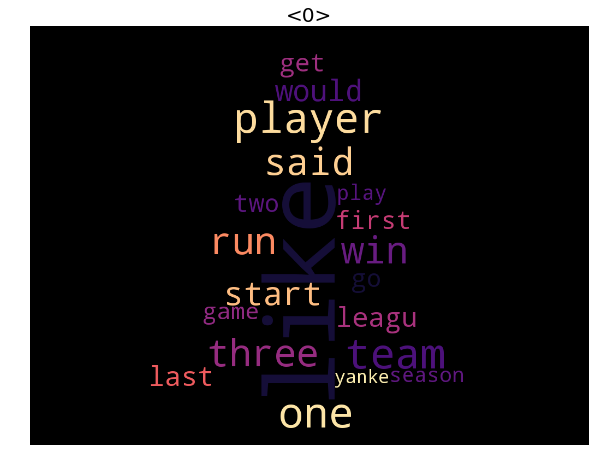

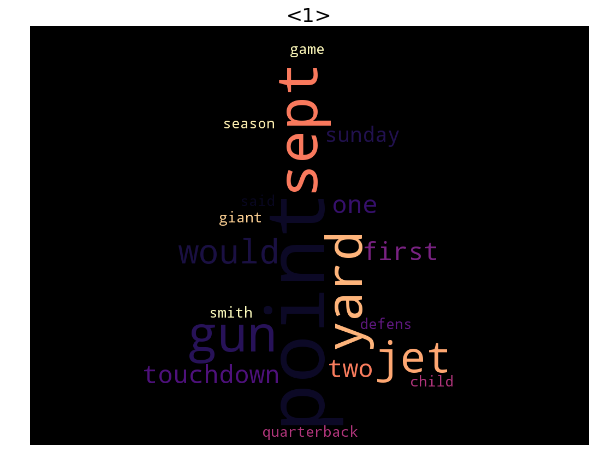

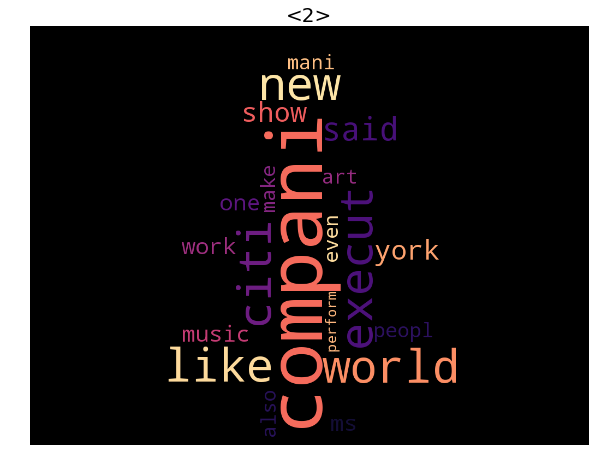

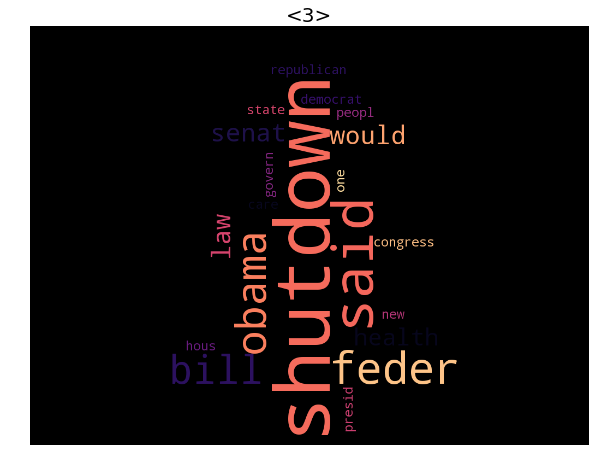

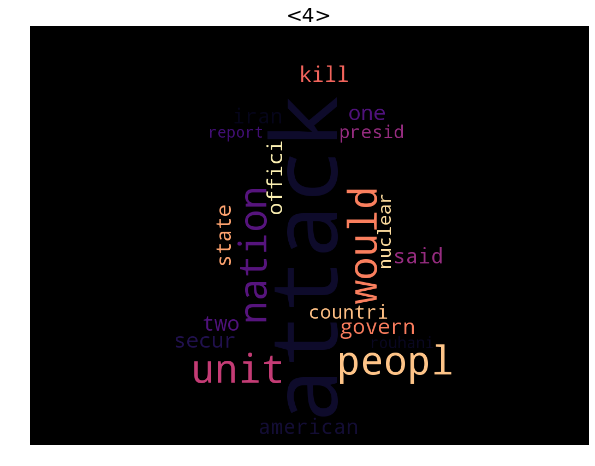

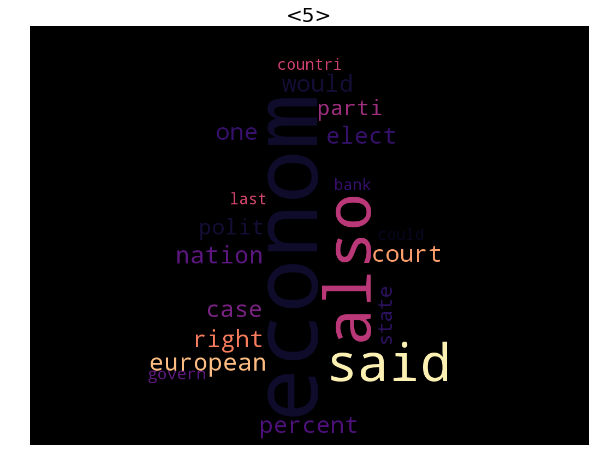

In [188]:
#Counting words, and draw wordcloud for each topic models for original content
print("Topics in LDA model:")
print_top_words(lda, Tf_feature_names)
print('='*75,'\n')

Topics in NMF model:

Topic0:
said | attack | kill | offici | govern | polic | peopl | state | court | militari | unit | secur | group | nation | syria | report | countri | war | parti | bomb

Topic1:
game | season | team | said | play | yanke | player | leagu | yard | win | run | coach | giant | first | two | score | inning | hit | rivera | start

Topic2:
republican | senat | hous | govern | health | parti | democrat | care | obama | vote | shutdown | law | bill | would | congress | presid | conserv | cruz | polit | debt

Topic3:
iran | rouhani | nuclear | iranian | obama | israel | unit | netanyahu | presid | weapon | negoti | state | speech | syria | nation | meet | diplomat | leader | american | program

Topic4:
ms | music | work | new | like | one | show | art | perform | york | danc | said | song | play | world | artist | peopl | make | night | life

Topic5:
percent | compani | market | bank | said | rate | million | china | price | economi | govern | would | billion | econom | b

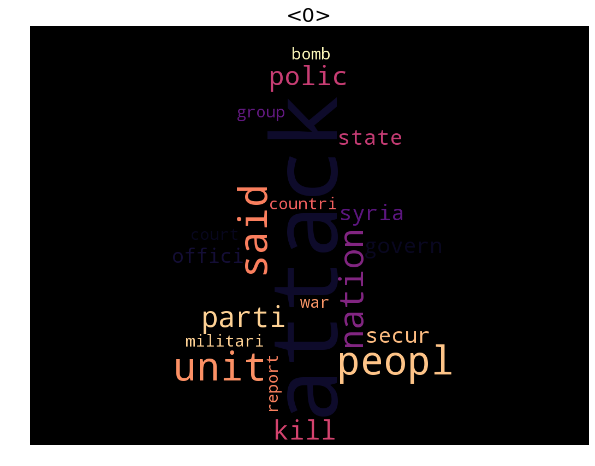

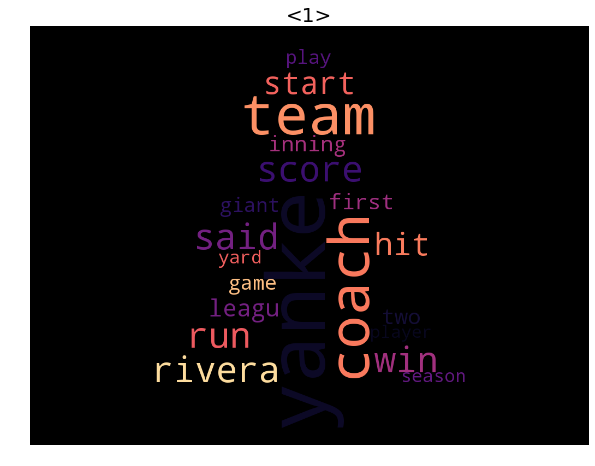

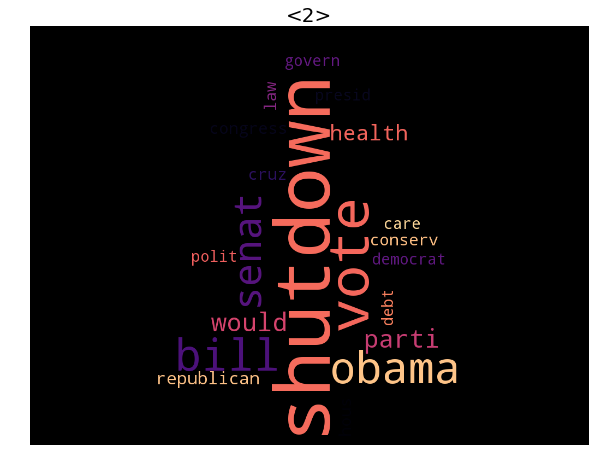

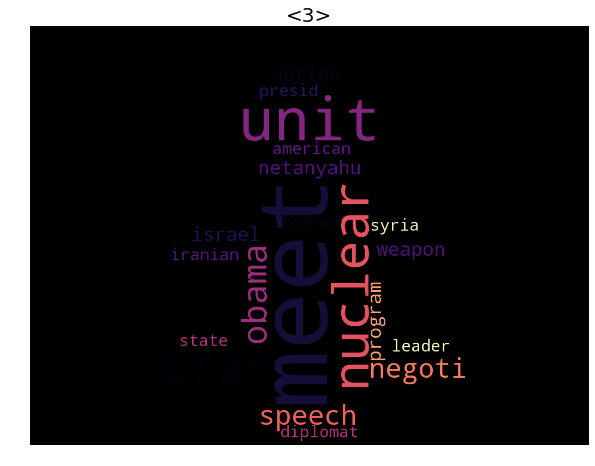

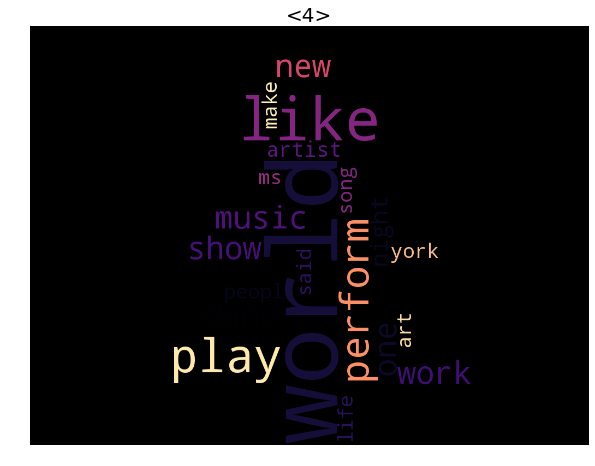

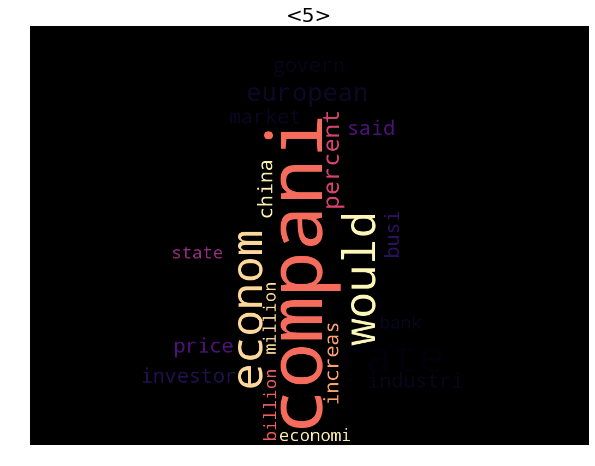

In [189]:
print("Topics in NMF model:")
print_top_words(nmf, Tfidf_feature_names)
print('='*75,'\n')

In [197]:
# make dictionary
dictionary = corpora.Dictionary(new_nyt['content'].values)

In [200]:
# There are 25324 distinct words in the processed corpus, 
# which means each document will be represented by 25324 numbers (ie., by a 25324-D vector). 
# To see the mapping between words and their ids:
len(list(dictionary))

25324

In [208]:
dictionary.token2id

{'willpow': 13641,
 'weareon': 17399,
 'shostakovich': 5630,
 'bastard': 9731,
 'kiir': 831,
 'myriad': 3380,
 'happen': 1274,
 'castamer': 22110,
 'dexter': 3618,
 'prelud': 1478,
 'owe': 6127,
 'db': 23914,
 'stockhold': 12818,
 'desmond': 22285,
 'benz': 23177,
 'happel': 23777,
 'hilux': 22411,
 'que': 24779,
 'coukel': 17725,
 'bulat': 13922,
 'stockman': 25186,
 'nontradit': 19667,
 'gross': 6701,
 'napl': 18664,
 'solidifi': 3478,
 'fred': 1300,
 '81': 14,
 'konto': 23247,
 'vanguard': 12613,
 'astair': 18297,
 'sedin': 17014,
 'shelf': 5107,
 'poulenc': 10973,
 'epidemiolog': 13247,
 'diabet': 6414,
 'rule': 210,
 'frustrat': 3127,
 'doubront': 21586,
 'cloak': 7889,
 'arian': 19088,
 'stool': 17793,
 'kander': 24733,
 'overambiti': 24813,
 'hirsut': 22755,
 'estrada': 19858,
 'shaq': 19020,
 'franchise': 20024,
 'stalin': 5682,
 'bounia': 3737,
 'inadequ': 3373,
 'polyest': 23796,
 'numb': 17729,
 '1961': 5871,
 '178': 16488,
 'dens': 14863,
 'gad': 10643,
 'dogana': 17146,
 '

In [211]:
# The doc2bow() function converts dictionary into a bag-of-words. 
# The result, corpus, is a list of vectors equal to the number of documents. 
# In each document vector is a series of tuples. As an example, print(corpus[0]) results in the following:

In [209]:
# dictionary must be converted into a bag-of-words
corpus = [dictionary.doc2bow(content) for content in new_nyt['content'].values]

In [212]:
len(corpus)

1399

In [210]:
print(corpus[0])

[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 4), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 4), (16, 4), (17, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 4), (23, 4), (24, 8), (25, 2), (26, 2), (27, 6), (28, 2), (29, 10), (30, 2), (31, 4), (32, 2), (33, 2), (34, 2), (35, 2), (36, 2), (37, 4), (38, 4), (39, 2), (40, 4), (41, 2), (42, 2), (43, 2), (44, 2), (45, 2), (46, 2), (47, 6), (48, 2), (49, 20), (50, 4), (51, 4), (52, 2), (53, 4), (54, 2), (55, 6), (56, 2), (57, 2), (58, 2), (59, 2), (60, 2), (61, 2), (62, 4), (63, 2), (64, 2), (65, 2), (66, 2), (67, 2), (68, 4), (69, 18), (70, 4), (71, 4), (72, 4), (73, 2), (74, 6), (75, 2), (76, 2), (77, 2), (78, 2), (79, 2), (80, 6), (81, 2), (82, 4), (83, 2), (84, 2), (85, 6), (86, 16), (87, 2), (88, 2), (89, 6), (90, 4), (91, 2), (92, 2), (93, 2), (94, 2), (95, 2), (96, 2), (97, 2), (98, 2), (99, 2), (100, 2), (101, 2), (102, 2), (103, 24), (104, 2), (105, 2), (106, 2), (107, 6), (108, 2), (109, 4), (110

In [213]:
# corpus is a document-term matrix and now ready to generate an LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=6, id2word=dictionary, passes=20)

* num_topics(Require): Number of Topic for LDA model (NYT 6 Sections after cleanning).
* id2word(Require): LdaModel class requires dictionary to map ids to strings.
* passes(Option): The number of laps the model will take through corpus. The greater the number of passes, the more accurate the model will be. A lot of passes can be slow on a very large corpus.

In [217]:
lda_model.print_topics(num_topics=6, num_words=10)

[(0,
  '0.011*"said" + 0.008*"season" + 0.008*"game" + 0.007*"play" + 0.006*"first" + 0.006*"one" + 0.005*"two" + 0.004*"team" + 0.004*"like" + 0.004*"new"'),
 (1,
  '0.011*"said" + 0.006*"new" + 0.005*"one" + 0.005*"attack" + 0.004*"two" + 0.004*"art" + 0.004*"peopl" + 0.003*"group" + 0.003*"game" + 0.003*"kill"'),
 (2,
  '0.014*"said" + 0.008*"govern" + 0.007*"state" + 0.006*"would" + 0.006*"percent" + 0.004*"compani" + 0.004*"million" + 0.004*"new" + 0.003*"feder" + 0.003*"also"'),
 (3,
  '0.012*"said" + 0.006*"one" + 0.006*"team" + 0.005*"new" + 0.005*"would" + 0.004*"peopl" + 0.004*"compani" + 0.004*"like" + 0.003*"work" + 0.003*"citi"'),
 (4,
  '0.008*"republican" + 0.007*"said" + 0.006*"would" + 0.006*"hous" + 0.005*"new" + 0.005*"one" + 0.005*"like" + 0.005*"govern" + 0.005*"health" + 0.004*"law"'),
 (5,
  '0.013*"said" + 0.008*"iran" + 0.007*"unit" + 0.006*"yanke" + 0.006*"would" + 0.005*"nuclear" + 0.005*"state" + 0.005*"nation" + 0.005*"presid" + 0.005*"rouhani"')]

### Will Try Simple unsupervised NN Model with X:[Bag of Word (Vector corpus)] + Y:[Section Label] as Input.

* 2 Dense Layers
* 2 Dropout
* softMax

### Experiment NN & NNP focused

In [20]:
#POStagging for each section
Trdf['content'] = Trdf['content'].apply(lambda x: nltk.pos_tag(x))

In [21]:
#take out 'NN' and 'NNP' from each section
filt = ['NN', 'NNP']
Trdf['content'] = Trdf['content'].apply(lambda x: [i[0] for i in x if i[1] in filt])

In [22]:
#clean the data for , [, ] and make lowercase letter
Trdf['content'] = Trdf['content'].apply(lambda x: str(x).replace("', '", " ").replace("['", " ").replace("']", " "))

In [23]:
Trdf.head(2)

,section_name,content
0,Sports,goal building model football forecasting impo...
1,U.S.,house immigration bill citizenship border sec...


#### Cleaning Data for sum_Df (Combine content all NN and NNP words from each sections, so only 6 rows(sections) for df ).

In [24]:
#groupby section in order to count the most freq words in each section.
Sp = df[df.section_name == 'Sports']
US = df[df.section_name == 'U.S.']
BuD = df[df.section_name == 'Business Day']
Wr = df[df.section_name == 'World']
Op = df[df.section_name == 'Opinion']
Ar = df[df.section_name == 'Arts']

In [25]:
#conbine content by section
Sp = sum(Sp.content)
US = sum(US.content)
BuD = sum(BuD.content)
Wr = sum(Wr.content)
Op = sum(Op.content)
Ar = sum(Ar.content)

In [26]:
#make lower case letter and clean punctuation
Sp = Sp.replace("'", " ").replace(":", " ").replace(".", " ").lower()
US = US.replace("'", " ").replace(":", " ").replace(".", " ").lower()
BuD = BuD.replace("'", " ").replace(":", " ").replace(".", " ").lower()
Wr = Wr.replace("'", " ").replace(":", " ").replace(".", " ").lower()
Op = Op.replace("'", " ").replace(":", " ").replace(".", " ").lower()
Ar = Ar.replace("'", " ").replace(":", " ").replace(".", " ").lower()

In [27]:
#tokenize each article into words(tokens)
RT = RegexpTokenizer(r'\w+')
token_Sp = RT.tokenize(Sp)
token_US = RT.tokenize(US)
token_BuD = RT.tokenize(BuD)
token_Wr = RT.tokenize(Wr)
token_Op = RT.tokenize(Op)
token_Ar = RT.tokenize(Ar)

In [28]:
#clean data like a, the ...
token_Sp = [i for i in token_Sp if i not in sw+noise_words]
token_US = [i for i in token_US if i not in sw+noise_words]
token_BuD = [i for i in token_BuD if i not in sw+noise_words]
token_Wr = [i for i in token_Wr if i not in sw+noise_words]
token_Op = [i for i in token_Op if i not in sw+noise_words]
token_Ar = [i for i in token_Ar if i not in sw+noise_words]

In [29]:
#total number of articles which are tokenized.
len(token_Sp), len(token_US), len(token_BuD), len(token_Wr), len(token_Op), len(token_Ar)

(229510, 156732, 168629, 183866, 142666, 150542)

In [30]:
#POStagging for Sport section
Tagtoken_Sp = nltk.pos_tag(token_Sp)

In [31]:
#POStagging for US section
Tagtoken_US = nltk.pos_tag(token_US)

In [32]:
#POStagging for Buisness Day section
Tagtoken_BuD = nltk.pos_tag(token_BuD)

In [33]:
#POStagging for World section
Tagtoken_Wr = nltk.pos_tag(token_Wr)

In [34]:
#POStagging for Opinion section
Tagtoken_Op = nltk.pos_tag(token_Op)

In [35]:
#POStagging for Arts section
Tagtoken_Ar = nltk.pos_tag(token_Ar)

In [36]:
#take out 'NN' and 'NNP' from Sports section
NN_Sp = [Tagtoken_Sp[i][0] for i in range(len(Tagtoken_Sp)) if Tagtoken_Sp[i][1] == 'NN']
NNP_Sp = [Tagtoken_Sp[i][0] for i in range(len(Tagtoken_Sp)) if Tagtoken_Sp[i][1] == 'NNP']

In [37]:
#take out 'NN' and 'NNP' from US section
NN_US = [Tagtoken_US[i][0] for i in range(len(Tagtoken_US)) if Tagtoken_US[i][1] == 'NN']
NNP_US = [Tagtoken_US[i][0] for i in range(len(Tagtoken_US)) if Tagtoken_US[i][1] == 'NNP']

In [38]:
#take out 'NN' and 'NNP' from Buisness Day section
NN_BuD = [Tagtoken_BuD[i][0] for i in range(len(Tagtoken_BuD)) if Tagtoken_BuD[i][1] == 'NN']
NNP_BuD = [Tagtoken_BuD[i][0] for i in range(len(Tagtoken_BuD)) if Tagtoken_BuD[i][1] == 'NNP']

In [39]:
#take out 'NN' and 'NNP' from World section
NN_Wr = [Tagtoken_Wr[i][0] for i in range(len(Tagtoken_Wr)) if Tagtoken_Wr[i][1] == 'NN']
NNP_Wr = [Tagtoken_Wr[i][0] for i in range(len(Tagtoken_Wr)) if Tagtoken_Wr[i][1] == 'NNP']

In [40]:
#take out 'NN' and 'NNP' from Opinion section
NN_Op = [Tagtoken_Op[i][0] for i in range(len(Tagtoken_Op)) if Tagtoken_Op[i][1] == 'NN']
NNP_Op = [Tagtoken_Op[i][0] for i in range(len(Tagtoken_Op)) if Tagtoken_Op[i][1] == 'NNP']

In [41]:
#take out 'NN' and 'NNP' from Arts section
NN_Ar = [Tagtoken_Ar[i][0] for i in range(len(Tagtoken_Ar)) if Tagtoken_Ar[i][1] == 'NN']
NNP_Ar = [Tagtoken_Ar[i][0] for i in range(len(Tagtoken_Ar)) if Tagtoken_Ar[i][1] == 'NNP']

In [42]:
#Counting most freq words(NN, NNP) in each section
print('Sports')
print('-------------------------------------------------------------------------------------------------------------------')
count_NN_Sp = Counter(NN_Sp).most_common(15)
count_NNP_Sp = Counter(NNP_Sp).most_common(5)
print('10 Most Frequency Words(NN) in Sports :\n', count_NN_Sp)
print('\n5 Most Frequency Words(NNP) in Sports :\n', count_NNP_Sp)
print('-------------------------------------------------------------------------------------------------------------------\n')

print('U.S.')
print('-------------------------------------------------------------------------------------------------------------------')
count_NN_US = Counter(NN_US).most_common(15)
count_NNP_US = Counter(NNP_US).most_common(5)
print('10 Most Frequency Words(NN) in U.S. :\n', count_NN_US)
print('\n5 Most Frequency Words(NNP) in U.S. :\n', count_NNP_US)
print('-------------------------------------------------------------------------------------------------------------------\n')

print('Business Day')
print('-------------------------------------------------------------------------------------------------------------------')
count_NN_BuD = Counter(NN_BuD).most_common(15)
count_NNP_BuD = Counter(NNP_BuD).most_common(5)
print('10 Most Frequency Words(NN) in Business Day:\n', count_NN_BuD)
print('\n5 Most Frequency Words(NNP) in Business Day:\n', count_NNP_BuD)
print('-------------------------------------------------------------------------------------------------------------------\n')

print('World')
print('-------------------------------------------------------------------------------------------------------------------')
count_NN_Wr = Counter(NN_Wr).most_common(15)
count_NNP_Wr = Counter(NNP_Wr).most_common(5)
print('10 Most Frequency Words(NN) in World:\n', count_NN_Wr)
print('\n5 Most Frequency Words(NNP) in World:\n', count_NNP_Wr)
print('-------------------------------------------------------------------------------------------------------------------\n')

print('Opinion')
print('-------------------------------------------------------------------------------------------------------------------')
count_NN_Op = Counter(NN_Op).most_common(15)
count_NNP_Op = Counter(NNP_Op).most_common(5)
print('10 Most Frequency Words(NN) in Opinion:\n', count_NN_Op)
print('\n5 Most Frequency Words(NNP) in Opinion:\n', count_NNP_Op)
print('-------------------------------------------------------------------------------------------------------------------\n')

print('Arts')
print('-------------------------------------------------------------------------------------------------------------------')
count_NN_Ar = Counter(NN_Ar).most_common(15)
count_NNP_Ar = Counter(NNP_Ar).most_common(5)
print('10 Most Frequency Words(NN) in Arts :\n', count_NN_Ar)
print('\n5 Most Frequency Words(NNP) in Arts :\n', count_NNP_Ar)
print('-------------------------------------------------------------------------------------------------------------------')

Sports
-------------------------------------------------------------------------------------------------------------------
10 Most Frequency Words(NN) in Sports :
 [('game', 2484), ('season', 1996), ('team', 1939), ('player', 1042), ('league', 717), ('play', 557), ('point', 544), ('home', 484), ('yankee', 481), ('field', 480), ('l', 465), ('coach', 460), ('cup', 451), ('rivera', 450), ('race', 445)]

5 Most Frequency Words(NNP) in Sports :
 [('zealand', 39), ('kansa', 28), ('yankee', 24), ('özil', 18), ('september', 12)]
-------------------------------------------------------------------------------------------------------------------

U.S.
-------------------------------------------------------------------------------------------------------------------
10 Most Frequency Words(NN) in U.S. :
 [('state', 873), ('government', 791), ('law', 759), ('house', 733), ('health', 560), ('president', 491), ('care', 440), ('bill', 375), ('party', 337), ('court', 326), ('case', 315), ('member', 308

#### Visualize sum_Df data.

In [43]:
#make function drawing bar plot
def plotting(count_content, sec, tag):
    w = [count_content[i][1] for i in range(len(count_content))]
    c = [count_content[i][0] for i in range(len(count_content))]
    plt.figure(figsize=(10,4))
    plt.bar(range(len(w)), w)
    plt.xticks(range(len(c)), c, size=20, rotation=45)
    plt.title('{0} Section {1}'.format(sec, tag), size=20)
    plt.show()

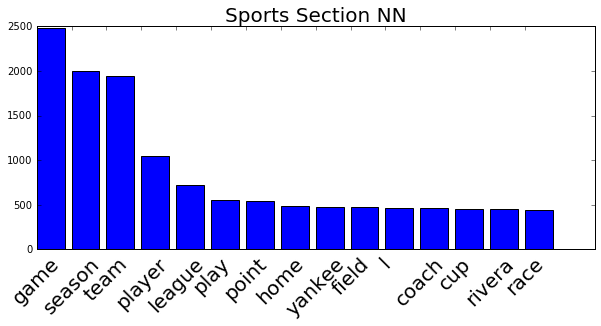

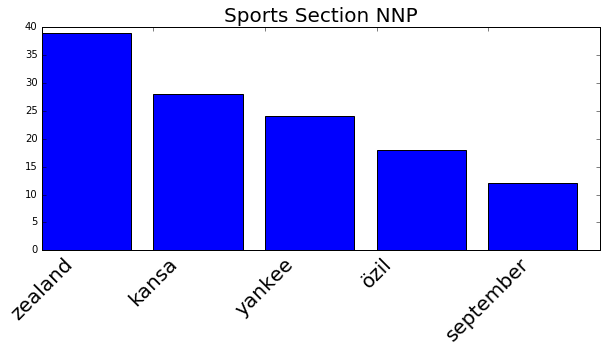

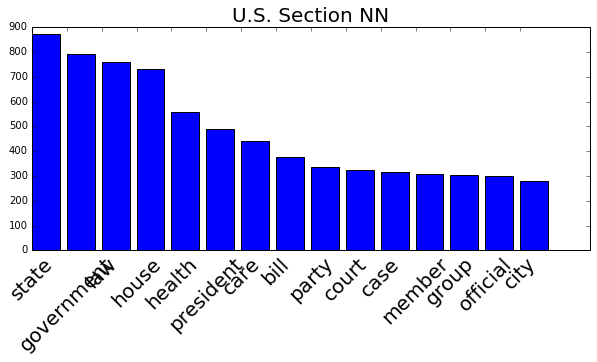

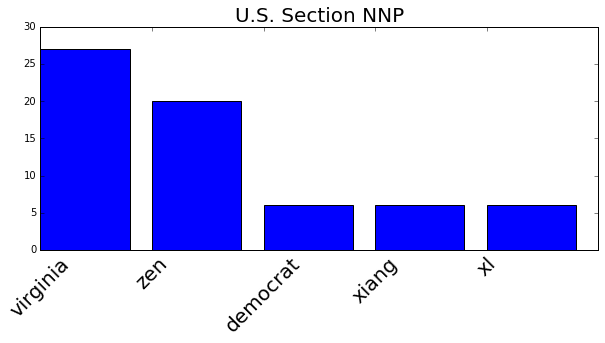

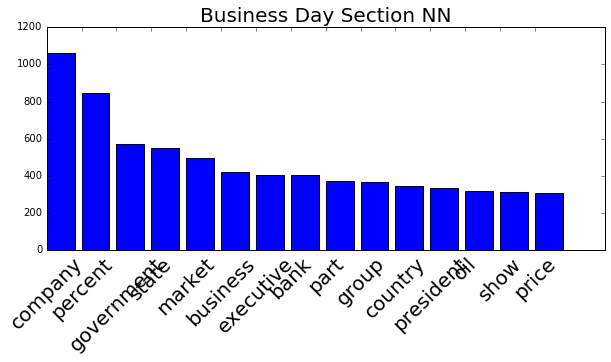

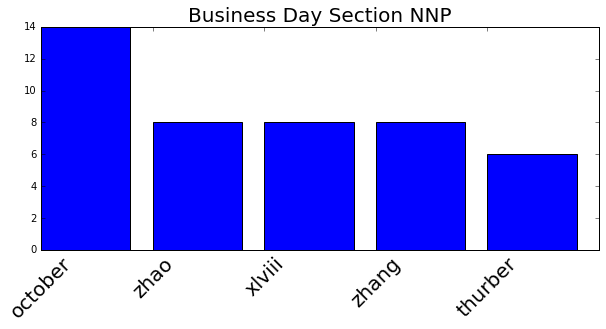

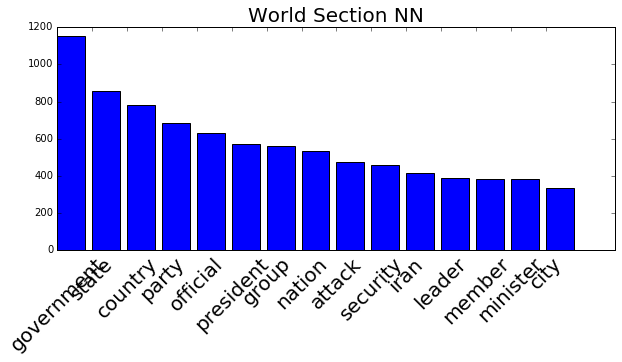

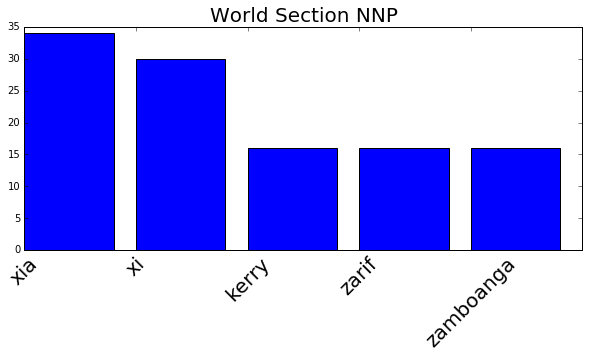

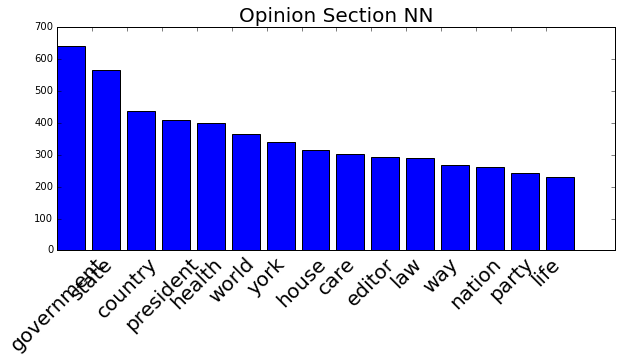

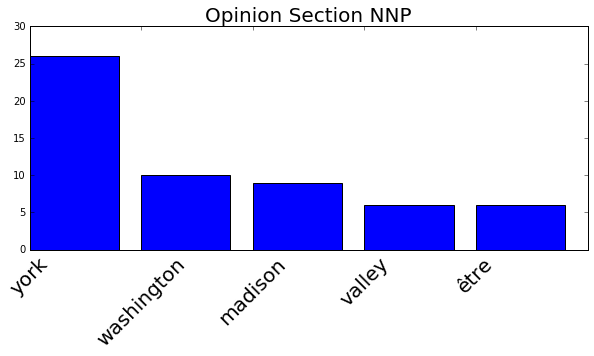

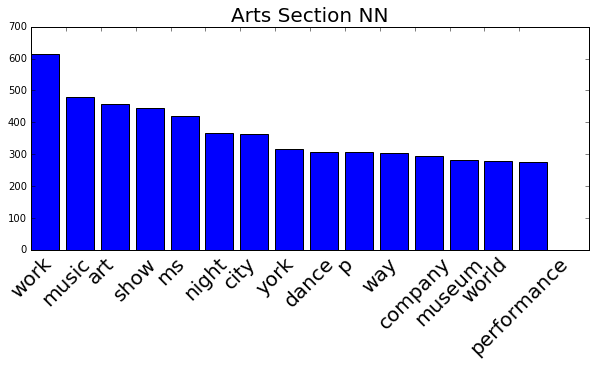

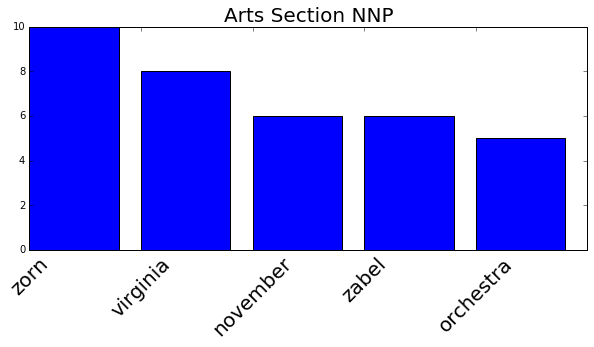

In [44]:
#Sports
plotting(count_NN_Sp, 'Sports', 'NN')
plotting(count_NNP_Sp, 'Sports', 'NNP')

#U.S.
plotting(count_NN_US, 'U.S.', 'NN')
plotting(count_NNP_US, 'U.S.', 'NNP')

#Business Day
plotting(count_NN_BuD, 'Business Day', 'NN')
plotting(count_NNP_BuD, 'Business Day', 'NNP')

#World
plotting(count_NN_Wr, 'World', 'NN')
plotting(count_NNP_Wr, 'World', 'NNP')

#Opinion
plotting(count_NN_Op, 'Opinion', 'NN')
plotting(count_NNP_Op, 'Opinion', 'NNP')

#Arts
plotting(count_NN_Ar, 'Arts', 'NN')
plotting(count_NNP_Ar, 'Arts', 'NNP')

In [45]:
#clean the data for , [, ] and make lowercase letter
Sp = str(NN_Sp + NNP_Sp).replace("', '", " ").replace("['", " ").replace("]", " ").lower()
US = str(NN_US + NNP_US).replace("', '", " ").replace("['", " ").replace("]", " ").lower()
BuD = str(NN_BuD + NNP_BuD).replace("', '", " ").replace("['", " ").replace("]", " ").lower()
Wr = str(NN_Wr + NNP_Wr).replace("', '", " ").replace("['", " ").replace("]", " ").lower()
Op = str(NN_Op + NNP_Op).replace("', '", " ").replace("['", " ").replace("]", " ").lower()
Ar = str(NN_Ar + NNP_Ar).replace("', '", " ").replace("['", " ").replace("]", " ").lower()

In [46]:
#make train data for train for doc2vec
#output(Trdf) consist of all conbined words(NN and NNP) in each sections
Data = {'Sports': Sp,
         'U.S.': US, 
         'Business Day': BuD, 
         'World': Wr,
         'Opinion': Op,
         'Arts': Ar}
sum_Df = pd.DataFrame(Data, index = ['content']).T
sum_Df = sum_Df.reset_index()
sum_Df = sum_Df.rename(index=str, columns={'index': 'section'})
sum_Df

,section,content
0,Arts,matter spouse television crucial season netwo...
1,Business Day,farmer waste management company energy indust...
2,Opinion,editor interest sister chekhov joe nocera col...
3,Sports,goal building model football forecasting impo...
4,U.S.,house immigration bill citizenship border sec...
5,World,juba south fashion model woman heel dirt catw...


#### | Original Data with Topic Modeling (LDA) |    VS.   |  NN & NNP Combination Data with Counter |

#### Draw wordcloud with NN and NNP combination.

* For NN and NNP content

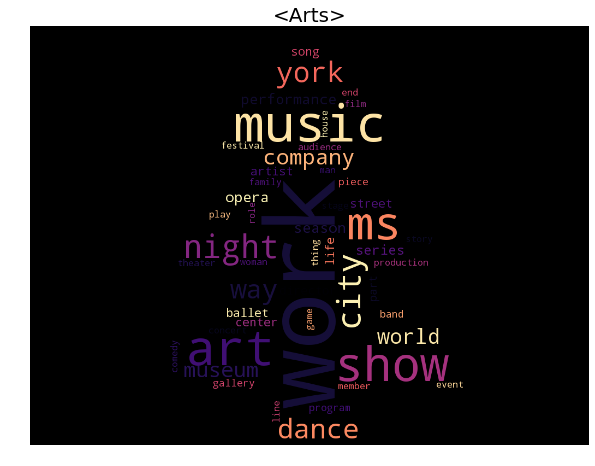

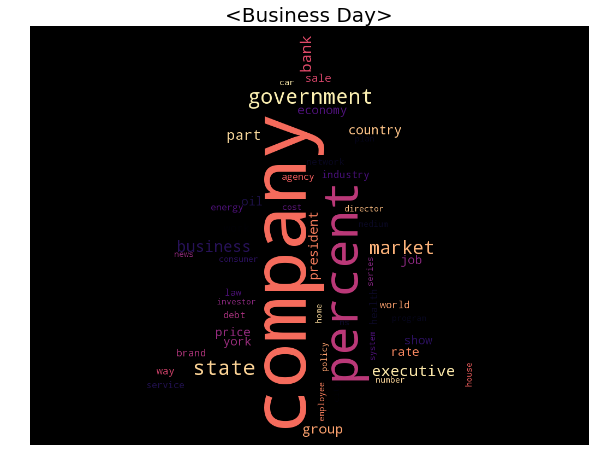

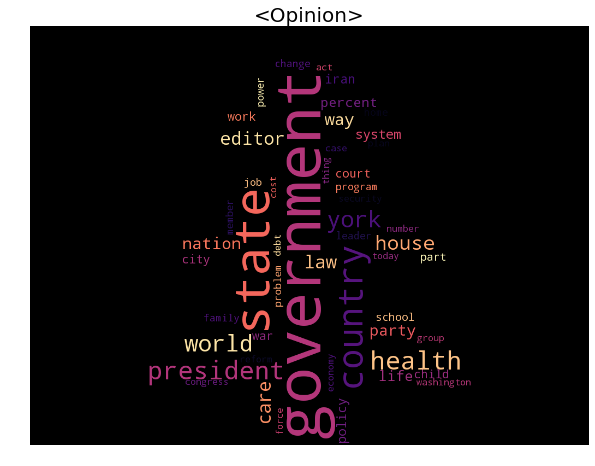

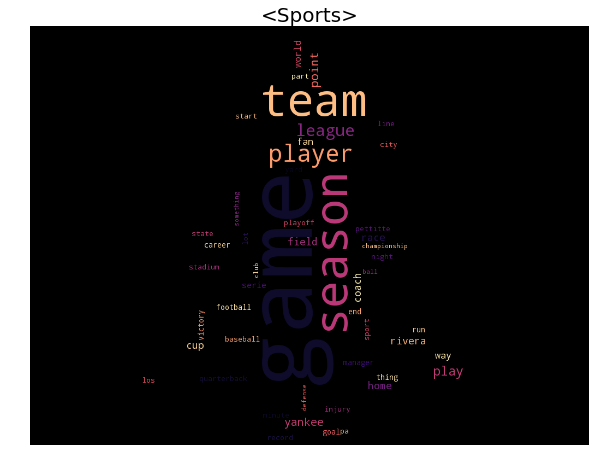

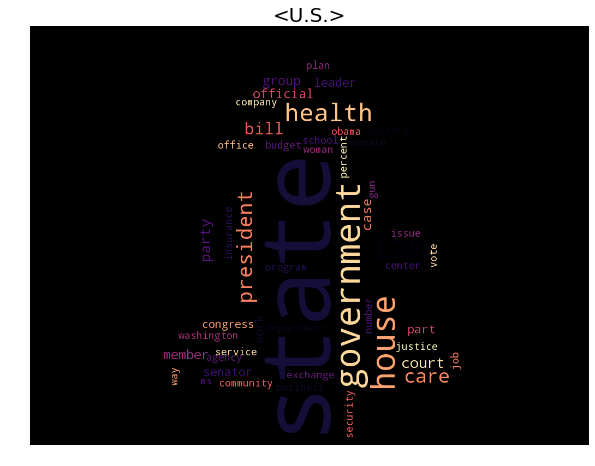

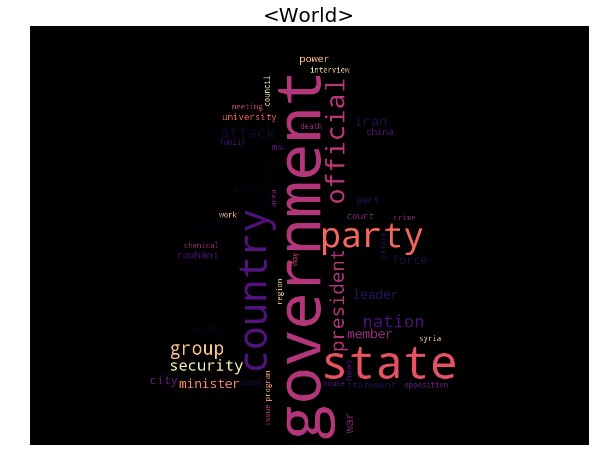

In [54]:
#wordcloud for Counting NN NNP words
for i in range(len(list_sec)):
    TreeCloud(sum_Df.content[i], list_sec[i])

>From the words cloud, the words in the word cloud are really good explain for each sections.

>Hance, 'NN', 'NNP' are contain the most of imformations for news articles based on these 1399 New York Times data set.

#### Apply doc2vec

In [88]:
#labels functions
def Labeled(content, label):
    sentence = []
    for i, doc in enumerate(content):
        sentence.append(LabeledSentence(utils.to_unicode(doc).split(),[label[i]]))
    return sentence

In [101]:
#set up training data for dec2vec for x(content) and y(labels or sections)
content = sum_Df.content
label = sum_Df.section

#Generate vocabrary
Tr = Labeled(content, label)
model = gensim.models.Doc2Vec(size=300, 
                              window=20, 
                              min_count=5, 
                              workers=11,
                              alpha=0.025, 
                              min_alpha=0.025,
                              negative=5,
                              dm=1)
model.build_vocab(Tr)

#Training model 10 literation to apply statistical results
print('Let start Making Tree~~^^\n')
print('  Merry')
print('Christ Mas')
for epoch in range(10):
    n = epoch + 1
    print('.'*n)
    print('..'*n)
    print('*..'*n)
    model.train(Tr)
    print('.*..'*n)
    model.alpha -= 0.002 
    model.min_alpha = model.alpha
    print('...*.'*n)
    model.train(Tr)
    print('.*..*.'*n)
print('............')
print('............')
print('............')
print('............')
print('............')
print('............')
print('\nTALA~ I am Making Christmas Tree~~.')
model.save('doc2vecNYT.model')

Let start Making Tree~~^^

  Merry
Christ Mas
.
..
*..
.*..
...*.
.*..*.
..
....
*..*..
.*...*..
...*....*.
.*..*..*..*.
...
......
*..*..*..
.*...*...*..
...*....*....*.
.*..*..*..*..*..*.
....
........
*..*..*..*..
.*...*...*...*..
...*....*....*....*.
.*..*..*..*..*..*..*..*.
.....
..........
*..*..*..*..*..
.*...*...*...*...*..
...*....*....*....*....*.
.*..*..*..*..*..*..*..*..*..*.
......
............
*..*..*..*..*..*..
.*...*...*...*...*...*..
...*....*....*....*....*....*.
.*..*..*..*..*..*..*..*..*..*..*..*.
.......
..............
*..*..*..*..*..*..*..
.*...*...*...*...*...*...*..
...*....*....*....*....*....*....*.
.*..*..*..*..*..*..*..*..*..*..*..*..*..*.
........
................
*..*..*..*..*..*..*..*..
.*...*...*...*...*...*...*...*..
...*....*....*....*....*....*....*....*.
.*..*..*..*..*..*..*..*..*..*..*..*..*..*..*..*.
.........
..................
*..*..*..*..*..*..*..*..*..
.*...*...*...*...*...*...*...*...*..
...*....*....*....*....*....*....*....*....*.
.*..*..*..

In [90]:
#load model 
model = gensim.models.Doc2Vec.load("doc2vecNYT.model")

In [91]:
#In order to compare two documents, I need call function like this.
'''
model.docvecs.similarity(d1, d2)

Input: d1 and d2 (compare documents or content)
Output: similarity scores
'''

'\nmodel.docvecs.similarity(d1, d2)\n\nInput: d1 and d2 (compare documents or content)\nOutput: similarity scores\n'

#### Test dec2vec Model for similarity for words.

In [92]:
model.most_similar('france')

[('homosexuality', 0.35544562339782715),
 ('homeland', 0.34970760345458984),
 ('nancy', 0.3263286352157593),
 ('salon', 0.32003456354141235),
 ('chant', 0.31590402126312256),
 ('manhattan', 0.30812323093414307),
 ('differ', 0.3010605573654175),
 ('miracle', 0.300906240940094),
 ('lap', 0.29843416810035706),
 ('gravity', 0.2972208857536316)]

In [93]:
'''
positive words from the most freq. words in Arts section,
negative words from the most freq. words in Business Days section,
'''
model.most_similar(positive=[model['music'], 'art'], negative=[model['company'], 'percent'])

[('music', 0.7405447363853455),
 ('u', 0.26838207244873047),
 ('watson', 0.23952439427375793),
 ('science', 0.23586341738700867),
 ('st', 0.21793174743652344),
 ('medium', 0.2117912769317627),
 ('schneider', 0.20738132297992706),
 ('criticism', 0.20700141787528992),
 ('patriot', 0.20623233914375305),
 ('idea', 0.20591270923614502)]

In [94]:
'''
positive words from the most freq. words in Sports section,
negative words from the most freq. words in Opinion section,
'''
model.most_similar(positive=[model['season'], model['game'], model['playoff'], 'yankee'], negative=[model['government'], 'state'])

[('playoff', 0.5617218613624573),
 ('game', 0.546448826789856),
 ('season', 0.39251258969306946),
 ('emergency', 0.2467181384563446),
 ('stone', 0.2273961752653122),
 ('swamp', 0.22668370604515076),
 ('listener', 0.22020535171031952),
 ('mrs', 0.21794536709785461),
 ('rusher', 0.2159302830696106),
 ('tristan', 0.2158953845500946)]

In [95]:
#Find the top 10 most similar words. Positive words contribute positively towards the similarity, negative words negatively.
model.most_similar(positive=[model['war'], model['bomb'], 'war'])

[('bomb', 0.5509645342826843),
 ('luggage', 0.31320762634277344),
 ('capital', 0.29124969244003296),
 ('millionaire', 0.25755953788757324),
 ('lincoln', 0.25648173689842224),
 ('simpson', 0.25407201051712036),
 ('report', 0.25221002101898193),
 ('jonathan', 0.24949946999549866),
 ('serve', 0.23862537741661072),
 ('concession', 0.2373114973306656)]

In [96]:
model.most_similar_cosmul(positive=['baghdad', 'england'], negative=['london'])

[('nashville', 0.8672575354576111),
 ('insurgent', 0.8623152375221252),
 ('appropriation', 0.8314728140830994),
 ('kansa', 0.8149935603141785),
 ('agriculture', 0.8086455464363098),
 ('pollution', 0.7998626232147217),
 ('catalog', 0.7990890145301819),
 ('croatia', 0.7968136668205261),
 ('singing', 0.7930010557174683),
 ('concentrate', 0.792060136795044)]

In [97]:
#apply n_similarity for words
print('Similarity Score : {:.2%}'.format(model.n_similarity(['music', 'art'], ['art', 'music'])))
print('Similarity Score : {:.2%}'.format(model.n_similarity(['syria'], ['france'])))
print('Similarity Score : {:.2%}'.format(model.n_similarity(['team'], ['business'])))

Similarity Score : 100.00%
Similarity Score : 15.36%
Similarity Score : -4.98%


In [98]:
#calculate similarity score by comparing each sections
for i in range(len(sum_Df.section)):
    print('\n==={0}==========================================================================='.format(sum_Df.section[i]))
    for j in range(len(sum_Df.section)):
        print('Similarity Score between {0} and {1} section: {2:.2%}'.format(sum_Df.section[i], sum_Df.section[j], model.docvecs.similarity(i, j)))


===Arts===========================================================================
Similarity Score between Arts and Arts section: 100.00%
Similarity Score between Arts and Business Day section: 10.96%
Similarity Score between Arts and Opinion section: 6.58%
Similarity Score between Arts and Sports section: 8.09%
Similarity Score between Arts and U.S. section: 5.83%
Similarity Score between Arts and World section: 5.49%

===Business Day===========================================================================
Similarity Score between Business Day and Arts section: 10.96%
Similarity Score between Business Day and Business Day section: 100.00%
Similarity Score between Business Day and Opinion section: 18.36%
Similarity Score between Business Day and Sports section: 14.63%
Similarity Score between Business Day and U.S. section: 22.45%
Similarity Score between Business Day and World section: 18.87%

===Opinion===========================================================================
Sim